# 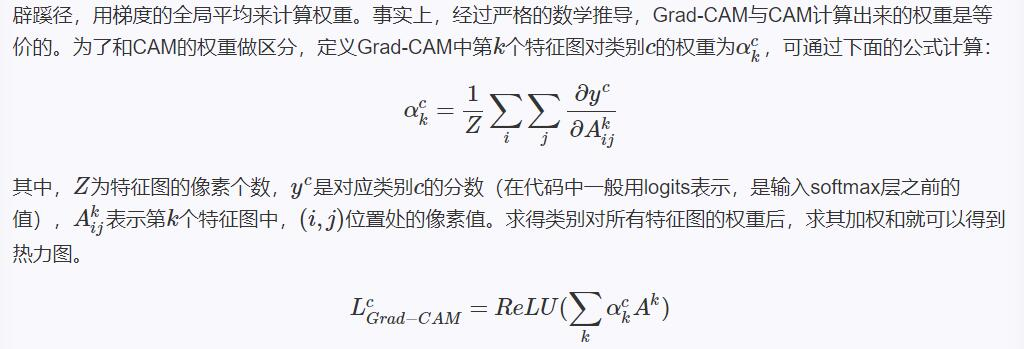

In [1]:
from keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import cv2
import os

K.clear_session()
from keras.models import load_model

E:\software\Anaconda3\envs\python3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
E:\software\Anaconda3\envs\python3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\software\Anaconda3\envs\python3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\software\Anaconda3\envs\python3\lib\si

In [2]:
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def deprocess_image(x):
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
            
def grad_cam(model, x, category_index, layer_name):
    """
    Args:
       model: model
       x: image input
       category_index: category index
       layer_name: last convolution layer name
    """
    # get category loss
    class_output = model.output[:, category_index]

    # layer output
    convolution_output = model.get_layer(layer_name).output
    # get gradients
    grads = K.gradients(class_output, convolution_output)[0]
    # get convolution output and gradients for input
    gradient_function = K.function([model.input], [convolution_output, grads])

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # avg
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # create heat map
    cam = cv2.resize(cam, (x.shape[1], x.shape[2]), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = x[0, :]
    image_rgb -= np.min(image_rgb)
    image_rgb = np.minimum(image_rgb, 255)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image_rgb)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [3]:
#***
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model('../models/cifar10/net_in_net.h5')
    return new_model

In [21]:
#***
model = load_model('../models/cifar10/net_in_net.h5')
#model.summary()


In [29]:
#***
def compile_saliency_function(model, activation_layer='activation_9'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [30]:
img = load_image('0_0.png')
predictions = model.predict(img)
predicted_class = np.argmax(predictions)
text = int(predicted_class)

cam_image, heat_map = grad_cam(model, img, predicted_class, "activation_9")

E:\software\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


In [28]:
# guided grad_cam img
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)

saliency = saliency_fn([img, 0])
grad_cam_img = saliency[0] * heat_map[..., np.newaxis]

# save img
#cam_image = cv2.resize(cam_image, (32, 32), cv2.INTER_LINEAR)
cam_image = cv2.resize(cam_image, (500, 500), cv2.INTER_LINEAR)
cv2.putText(cam_image,str(text), (20, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))
cv2.putText(cam_image,str(predictions[0][text]), (20, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))

grad_cam_img = deprocess_image(grad_cam_img)
#grad_cam_img = cv2.resize(grad_cam_img, (32, 32), cv2.INTER_LINEAR)
grad_cam_img = cv2.resize(grad_cam_img, (500, 500), cv2.INTER_LINEAR)
#cv2.putText(grad_cam_img,str(top_1[1]), (20, 20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))
#cv2.putText(grad_cam_img,str(top_1[2]), (20, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,(0, 0, 255))

#cam_image = cam_image.astype('float32')
#grad_cam_img = grad_cam_img.astype('float32')
#img = deprocess_image(img)
im_h = cv2.hconcat([cam_image, grad_cam_img])
#im_h = cv2.hconcat([cam_image])
cv2.imwrite('22.png', im_h)
print ('Done')

Done


In [17]:
print (cam_image.shape)

(32, 32, 3)
